In [1]:
# install libraries if not already installed, uncomment the following lines

import sys
# !{sys.executable} -m pip install opencv-python opencv-contrib-python matplotlib numpy torch torchvision pandas tqdm scikit-learn seaborn transformers datasets accelerate

In [2]:
import torchvision.transforms as transforms
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch


In [3]:
from src import dataloader as ds
from src import models as m
from src import training as t
from src import evaluation as eval


In [4]:
file_path = 'fer2013.tar.gz'
data_path = ds.unpack_tar_gz(file_path)

Target folder 'data' is not empty. Assuming the file is already unpacked.


In [5]:
# dataset is available at https://www.kaggle.com/datasets/ashishpatel26/facial-expression-recognitionferchallenge
df = pd.read_csv(data_path)
print(df.shape)
df.head()

(35887, 3)


,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [6]:
emotion_label = {0: 'anger', 1: 'disgust', 2: 'fear', 3: 'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'}

In [7]:
df_mapped = df.copy()

# Map the emotion labels to their names
df_mapped['emotion'] = df_mapped['emotion'].map(emotion_label)

In [8]:
df_mapped.head()

,emotion,pixels,Usage
0,anger,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,anger,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,fear,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,sadness,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,neutral,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [9]:
df_mapped['Usage'].value_counts()

Usage
Training       28709
PublicTest      3589
PrivateTest     3589
Name: count, dtype: int64

In [10]:
df_mapped['emotion'].value_counts()
# get class weights of the training set

emotion
happiness    8989
neutral      6198
sadness      6077
fear         5121
anger        4953
surprise     4002
disgust       547
Name: count, dtype: int64

In [11]:
train_class_weights = df_mapped[df_mapped['Usage'] == 'Training']['emotion'].value_counts(normalize=True)
train_class_weights

emotion
happiness    0.251315
neutral      0.172942
sadness      0.168240
fear         0.142708
anger        0.139155
surprise     0.110453
disgust      0.015187
Name: proportion, dtype: float64

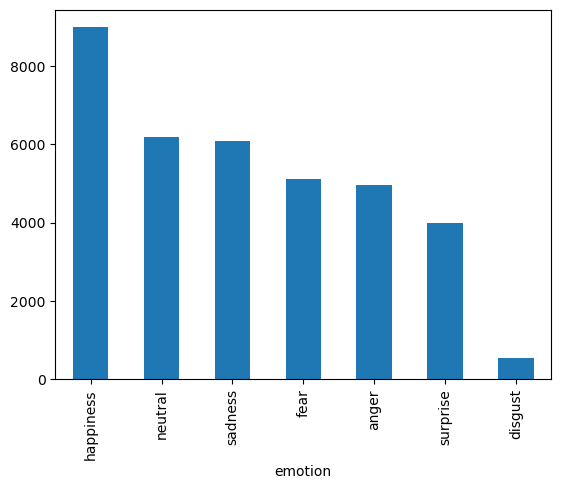

In [12]:
# plot the distribution of the emotions
df_mapped['emotion'].value_counts().plot(kind='bar')
plt.show()

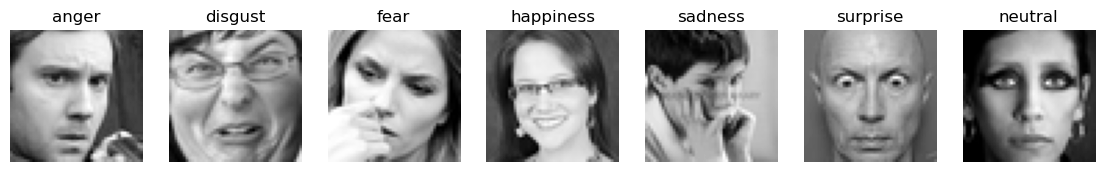

In [13]:
def pixels_to_image(pixels_str):
    pixels = np.fromstring(pixels_str, dtype=int, sep=' ')
    image = pixels.reshape(48, 48)
    return image


# plot each emotion
fig, axes = plt.subplots(1, 7, figsize=(14, 2))
for i in range(7):
    image = pixels_to_image(df[df['emotion'] == i].iloc[0]['pixels'])
    axes[i].imshow(image, cmap='gray')
    axes[i].set_title(emotion_label[i])
    axes[i].axis('off')

plt.show()

In [14]:
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(p=0.5),  # Randomly flip the image horizontally
    transforms.RandomRotation(degrees=10),   # Randomly rotate the image by up to 10 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  # Randomly change brightness, contrast, and saturation
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

batch_size = 64
train_loader, valid_loader, test_loader = ds.get_data_loaders(data_path, batch_size, train_transform)

Loaded 28709 samples for mode 'train'
Loaded 3589 samples for mode 'val'
Loaded 3589 samples for mode 'test'


In [15]:
train_class_weights = df[df['Usage'] == 'Training']['emotion'].value_counts(normalize=True)
train_class_weights = train_class_weights.sort_index().values
train_class_weights = torch.from_numpy(train_class_weights).float()
train_class_weights

tensor([0.1392, 0.0152, 0.1427, 0.2513, 0.1682, 0.1105, 0.1729])

In [18]:
model = m.SimpleCNN()
t.train(model, train_loader, valid_loader, train_class_weights, num_epochs=15)

Training:  96%|█████████▌| 429/449 [00:44<00:02,  9.61it/s, Train Loss=0.025, Accuracy=28.4] 


KeyboardInterrupt: 

In [ ]:
model = m.ComplexCNN()
t.train(model, train_loader, valid_loader, train_class_weights, num_epochs=15)

In [ ]:
model = m.CNNWithBatchNorm()
t.train(model, train_loader, valid_loader, train_class_weights, num_epochs=15)

In [ ]:
model = m.CNNWithLeakyReLU()
t.train(model, train_loader, valid_loader, train_class_weights, num_epochs=15)

In [ ]:
model = m.CNNWithMoreConvLayers()
t.train(model, train_loader, valid_loader, train_class_weights, num_epochs=15)

In [ ]:
model = m.CNNWithSmallerKernels()
t.train(model, train_loader, valid_loader, train_class_weights, num_epochs=15)

In [ ]:
model = m.CNNWithSmallerKernels()
t.train(model, train_loader, valid_loader, train_class_weights, num_epochs=15)

In [ ]:
model = m.ImprovedCNN()
t.train(model, train_loader, valid_loader, train_class_weights, num_epochs=15)

In [ ]:
# Evaluate the model
criterion = torch.nn.CrossEntropyLoss()
eval.evaluate_model(model, test_loader, criterion)

In [ ]:
# use saved model
criterion = torch.nn.CrossEntropyLoss()
model = m.load_model(m.SimpleCNN(), 'bestmodels/SimpleCNN_best_model.pth')
eval.evaluate_model(model, test_loader, criterion)

In [ ]:
# use saved model
model = m.load_model(m.SimpleCNN(), 'bestmodels/SimpleCNN_best_model_30_epochs.pth')

In [ ]:
for i in range(7):
    for image, label in test_loader:
        if label[0] == i:
            input_image = image[0]
            eval.plot_activations(model, input_image, emotion_label[i])
            break